In [2]:
import os

import pandas as pd
import numpy as np
import itertools
import geopandas as gpd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.transforms import ScaledTranslation

# TODO:
# * Short the legend following the color code

plt.rcParams['legend.handlelength'] = 1
plt.rcParams['legend.handleheight'] = 1.125
plt.rcParams["font.family"]         = "Avenir"
mpl.rcParams['pdf.fonttype'] = 42

mpl.rcParams.update({"pdf.use14corefonts": True})

path_to_scenarios = '/Users/Guille/Desktop/india_power/scenarios'
path_to_images    = '/Users/Guille/Desktop/india_power/images'

In [3]:
scen_labels_ = pd.read_csv('cost_scenario_labels.csv') 
tech_labels_ = pd.read_csv('technology_labels.csv') 

In [117]:
# Grab data from databases for plotting energy dispatch and clean energy targets
def _load_stor(scen_labels_):

    # Load energy dispatch table and process data from database
    def __load_soc_from_csv(df_, scenario, zone):
        
        df_ = df_.loc[(df_['operational_type'] == 'stor') | (df_['operational_type'] == 'stor_longterm')].reset_index(drop = True)
        
        df_ = df_[['period', 
                   'timepoint', 
                   'load_zone',
                   'technology', 
                   'starting_energy_mwh', 
                   'charge_mw', 
                   'discharge_mw']]
        
        df_ = df_.groupby(['period', 
                           'timepoint',
                           'load_zone',
                           'technology']).agg({'starting_energy_mwh': 'sum',
                                               'charge_mw': 'sum',
                                               'discharge_mw': 'sum'}).reset_index(drop = False)
        if zone == 'all':
            df_ = df_.groupby(['period', 
                               'timepoint',
                               'technology']).agg({'starting_energy_mwh': 'sum',
                                                   'charge_mw': 'sum',
                                                   'discharge_mw': 'sum'}).reset_index(drop = False)
        else:
            df_ = df_.loc[df_['load_zone'] == zone].reset_index(drop = True)
                
        df_['scenario'] = scenario
                
        return df_

    dfs_ = []
    # Open connection: open database and grab meta-data
    for scen, zone, path in zip(scen_labels_['scenario'], scen_labels_['zone'], scen_labels_['path']):
        print(scen, zone, path)
        
        dir_name  = r'{}/{}'.format(path, scen)
        dispatch_ = pd.read_csv(dir_name + f'/results/project_timepoint.csv', low_memory = False)
        
        dfs_ += [__load_soc_from_csv(dispatch_, scen, zone)]

    return pd.concat(dfs_, axis = 0).reset_index(drop = True)

soc_ = _load_stor(scen_labels_)
print(soc_)

VRElow_STlow_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid all /Users/Guille/Desktop/india_power/scenarios/cost
VRElow_STlow_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid all /Users/Guille/Desktop/india_power/scenarios/cost
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid all /Users/Guille/Desktop/india_power/scenarios/cost
VREmid_STmid_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid all /Users/Guille/Desktop/india_power/scenarios/cost
VREhigh_SThigh_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid all /Users/Guille/Desktop/india_power/scenarios/cost
VREhigh_SThigh_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid all /Users/Guille/Desktop/india_power/scenarios/cost
       period   timepoint    technology  starting_energy_mwh  charge_mw  \
0        2020  2020040101       Battery         0.000000e+00        0.0   
1        2020  2020040101  Hydro_Pumped         1.865160e+04        0.0   
2        2020  2020040101      Hydrogen         0.000000e+00        0.0 

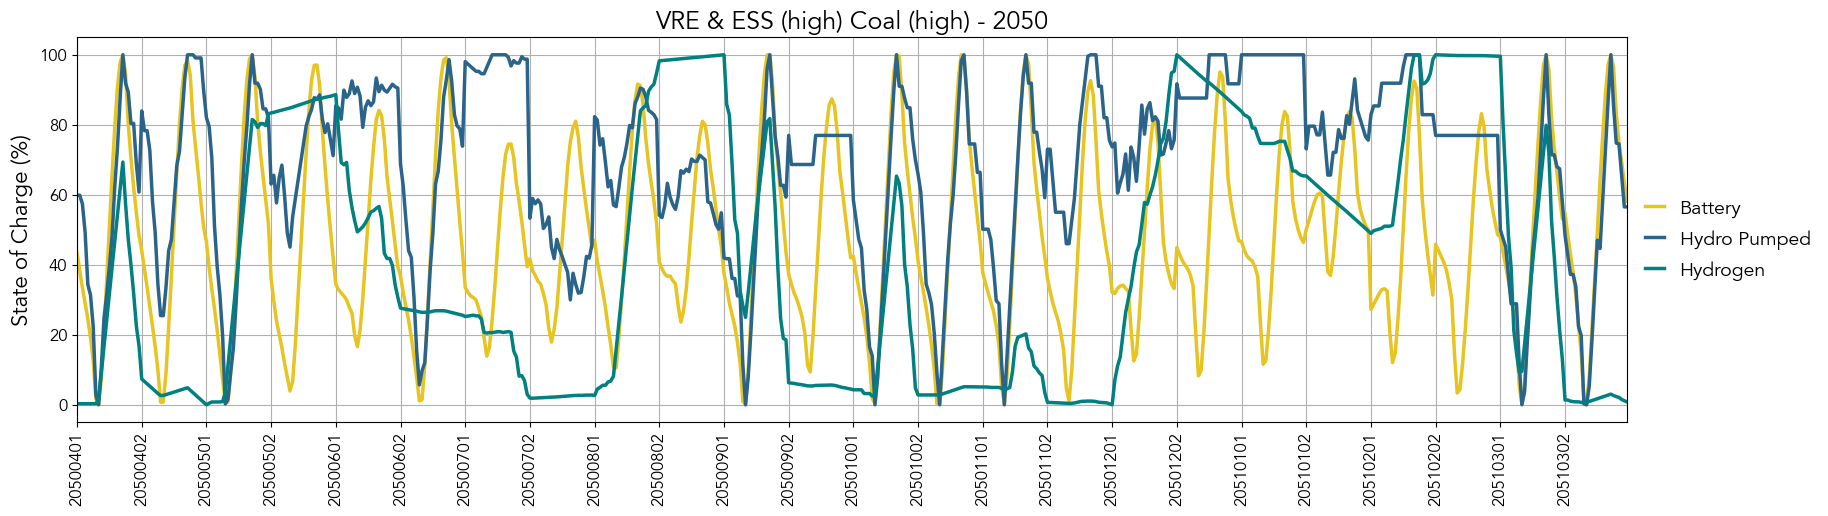

In [118]:
period = 2050
scen   = 'VREhigh_SThigh_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid'
legend = True

idx_   = (soc_['period'] == period) & (soc_['scenario'] == scen)
soc_p_ = soc_.loc[idx_].reset_index(drop = True).copy()
    
techs_ = soc_p_['technology'].unique()

fig = plt.figure(figsize = (20, 5))
ax = plt.subplot(111)

label = scen_labels_.loc[scen_labels_['scenario'] == scen, 'label'].to_numpy()[0]
title = f'{label} - {period}'
for tech in techs_:
    idx_    = (soc_p_['technology'] == tech)
    soc_pp_ = soc_p_.loc[idx_].reset_index(drop = True).copy()

    x_ = np.linspace(0, soc_pp_['timepoint'].shape[0] - 1, soc_pp_['timepoint'].shape[0])
    y_ = soc_pp_['starting_energy_mwh'].to_numpy()
    color = tech_labels_.loc[tech_labels_['technology'] == tech, 'color'].to_numpy()[0]

    if (y_ > 0.).sum() > 0.:
        y_ = 100.*y_/y_.max()
        ax.plot(x_, y_, label = tech.replace("_", " "), lw = 2.5, c = color)
        
    ax.set_ylabel(r'State of Charge (%)', fontsize = 16)

    ax.set_xticks(x_[::24], [str(x)[:-2] for x in soc_pp_['timepoint'].to_numpy()][::24], rotation = 90)

    ax.xaxis.set_tick_params(labelsize = 12)
    ax.yaxis.set_tick_params(labelsize = 12)

    ax.set_xlim(x_[0], x_[-1])
    # ax.set_ylim(0, 100)

    ax.set_title(title, fontsize = 18)
    
    if legend:
        ax.legend(loc            = 'center left', 
                  bbox_to_anchor = (1., 0.475),
                  frameon        = False,
                  prop           = {'size': 14})
        
plt.grid()
plt.show()

In [50]:
def _load_resource_adequacy_demand(scen_labels_):
    
    # Load energy dispatch table and process data from database
    def __load_demand_from_csv(df_, scenario, zone):

        df_ = df_[['period', 
                   'timepoint', 
                   'load_zone', 
                   'overgeneration_mw', 
                   'unserved_energy_mw', 
                   'static_load_mw']].copy()
        

        if zone != 'all':

            df_p_ = df_.groupby(['period', 
                                 'load_zone',
                                 'timepoint']).agg({'overgeneration_mw': 'sum', 
                                                    'unserved_energy_mw': 'sum', 
                                                    'static_load_mw': 'sum'}).reset_index(drop = False)

            df_p_ = df_p_['load_zone'].loc[df_p_['load_zone'] == zone].reset_index(drop = True)
        else:
            df_p_ = df_.groupby(['period', 
                                 'timepoint']).agg({'overgeneration_mw': 'sum', 
                                                    'unserved_energy_mw': 'sum', 
                                                    'static_load_mw': 'sum'}).reset_index(drop = False)
        
        df_['scenario'] = scenario
                                  
        return df_
    
    dfs_ = []
    # Open connection: open database and grab meta-data
    for scen, zone, path in zip(scen_labels_['scenario'], scen_labels_['zone'], scen_labels_['path']):
        print(scen, zone, path)
        
        dir_name = r'{}/{}'.format(path, scen)
        demand_  = pd.read_csv(dir_name + f'/results/system_load_zone_timepoint.csv', low_memory = False)
        
        dfs_ += [__load_demand_from_csv(demand_, scen, zone)]

    return pd.concat(dfs_, axis = 0).reset_index(drop = True)


def _resource_adequacy(df_):

    df_p_ = df_.copy()
    
    df_p_['demand_hr']       = (df_p_['static_load_mw'] > 0.)*1.
    df_p_['loss_of_load_hr'] = (df_p_['unserved_energy_mw'] > 0.)*1.

    df_p_['loss_of_load_freq']                                      = np.diff(df_p_['loss_of_load_hr'].to_numpy(), prepend = 0)
    df_p_.loc[df_p_['loss_of_load_freq'] < 0., 'loss_of_load_freq'] = 0.

    df_pp_ = df_p_.groupby(['period', 
                            'scenario']).agg({'overgeneration_mw': 'sum', 
                                              'unserved_energy_mw': 'sum', 
                                              'static_load_mw': 'sum', 
                                              'demand_hr': 'sum',
                                              'loss_of_load_hr': 'sum', 
                                              'loss_of_load_freq': 'sum'}).reset_index(drop = False)

    df_pp_['LOLP'] = df_pp_['loss_of_load_hr']/df_pp_['demand_hr']
    df_pp_['LOLF'] = df_pp_['loss_of_load_hr']/df_pp_['demand_hr']
    df_pp_['LOLD'] = df_pp_['loss_of_load_hr']/df_pp_['loss_of_load_freq']
    
    return df_pp_

demand_  = _load_resource_adequacy_demand(scen_labels_)
summary_ = _resource_adequacy(demand_)
print(summary_)

VRElow_STlow_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid all /Users/Guille/Desktop/india_power/scenarios/cost
VRElow_STlow_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid all /Users/Guille/Desktop/india_power/scenarios/cost
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid all /Users/Guille/Desktop/india_power/scenarios/cost
VREmid_STmid_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid all /Users/Guille/Desktop/india_power/scenarios/cost
VREhigh_SThigh_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid all /Users/Guille/Desktop/india_power/scenarios/cost
VREhigh_SThigh_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid all /Users/Guille/Desktop/india_power/scenarios/cost
    period                                           scenario  \
0     2020  VREhigh_SThigh_CONVhigh_H2_RES_10PRM_CC_50RPS_...   
1     2020  VREhigh_SThigh_CONVmid_H2_RES_10PRM_CC_50RPS_9...   
2     2020  VRElow_STlow_CONVhigh_H2_RES_10PRM_CC_50RPS_90...   
3     2020  VRElow_STlow_CONVmid_H2_R